In [120]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
import seaborn
import cv2

In [97]:
def compute_per_layer_pearsonc(grad_sim,acc1,acc2):
    p_task1 = {}
    p_task2 = {}
    for name, sim_value in grad_sim.items():
        p_task1[name]=pearsonr(np.array(acc1),np.array(sim_value))[0]
        p_task2[name]=pearsonr(np.array(acc2),np.array(sim_value))[0]
    return p_task1, p_task2
    

In [103]:
def plot_pearsonc(p_task1,lang1,p_task2,lang2):
    labels = p_task1.keys()
    #values = p_arabacc.values()
    fig, axs = plt.subplots(figsize=(20,8))
    axs.tick_params(axis='x', rotation=90)
    box = axs.get_position()
    axs.set_title('Comparing '+lang1+'-'+lang2+' per layer pearson correlation')
    axs.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    plt.scatter(list(labels), list(p_task1.values()),label=lang1)
    plt.scatter(list(labels),list(p_task2.values()),label=lang2)
    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs.set_xlabel('layers')
    axs.set_ylabel('pearson co-relation between gradient similarity and lang accurcay')
    axs.grid(True)
    plt.show()

    

In [134]:
#compute euclidean distance between correlation vectors
def norm1(a,b):
    a = np.array(a)
    b = np.array(b)
    return 1-np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [99]:
#AB
acc_AB_A = [1.915,5.426,10.106,13.085,19.149,20.319,19.894,23.723,26.170,24.787]
acc_AB_B = [5.591,19.441,28.463,29.352,35.070,31.258,36.595,32.656,36.595,36.341]

#BH
acc_BH_B = [8.259,29.860,36.849,37.357,41.550,39.517,43.456,42.058,42.313,45.743]
acc_BH_H = [8.418,34.056,38.903,45.281,45.153,45.918,47.449,48.214,48.214,47.959]

#AH
acc_AH_A = [2.553,5.319,10.638,13.830,17.553,17.766,21.915,20.319,24.574,25.426]
acc_AH_H = [7.526,19.898,28.827,32.398,33.418,34.184,36.990,38.138,39.668,39.031]

#pearsonr(np.array(acc_BH_B),np.array(acc_BH_H))

In [100]:
dumpAB = torch.load('gradinfo_AB.pth')
dumpBH = torch.load('gradinfo_BH.pth')
dumpAH = torch.load('gradinfo_AH.pth')
grad_sims = dumpAB['grad_sims']
grad_sims1 = dumpBH['grad_sims']
grad_sims_AH = dumpAH['grad_sims']

In [113]:
p_arabacc = {}
p_banacc_AB = {}
#print('gradient cosine and accuracy Correlation scores for ARAB-BAN\n')
for name,sims in grad_sims.items():
    p_arabacc[name]=pearsonr(np.array(acc_AB_A),np.array(sims))[0]
    p_banacc_AB[name]=pearsonr(np.array(acc_AB_B),np.array(sims))[0]
    #print(name)
    #print('correlation between gradient similarity and arab accuracy:',p_arabacc[name])
    #print('correlation between gradient similarity and ban accuracy:',p_banacc_AB[name])
    #print()

In [118]:
p_hinacc = {}
p_banacc = {}
i = 0
#print('gradient cosine and accuracy Correlation scores for Hin-BAN\n')
for name,sims in grad_sims1.items():
    p_hinacc[name]=pearsonr(np.array(acc_BH_H),np.array(sims))[0]
    p_banacc[name]=pearsonr(np.array(acc_BH_B),np.array(sims))[0]
    #print(name)
    #print('correlation between gradient similarity and hindi accuracy:',p_hinacc[name])
    #print('correlation between gradient similarity and ban accuracy:',p_banacc[name])
    #print()
#list(p_hinacc.values())

In [28]:
sum(p_banacc)/len(p_banacc)

0.3780566580236156

In [23]:
sum(p_hinacc)/len(p_hinacc)

0.5924139804953318

In [24]:
sum(p_banacc)/len(p_banacc)

0.5873428894708633

In [57]:
def multiplot(opt,x,sims):
    for module in ['FeatureExtraction.','rnn_lang.']:
        for para in ['weight','bias']:
            plot_grad_sim(opt,x,sims,module,para)

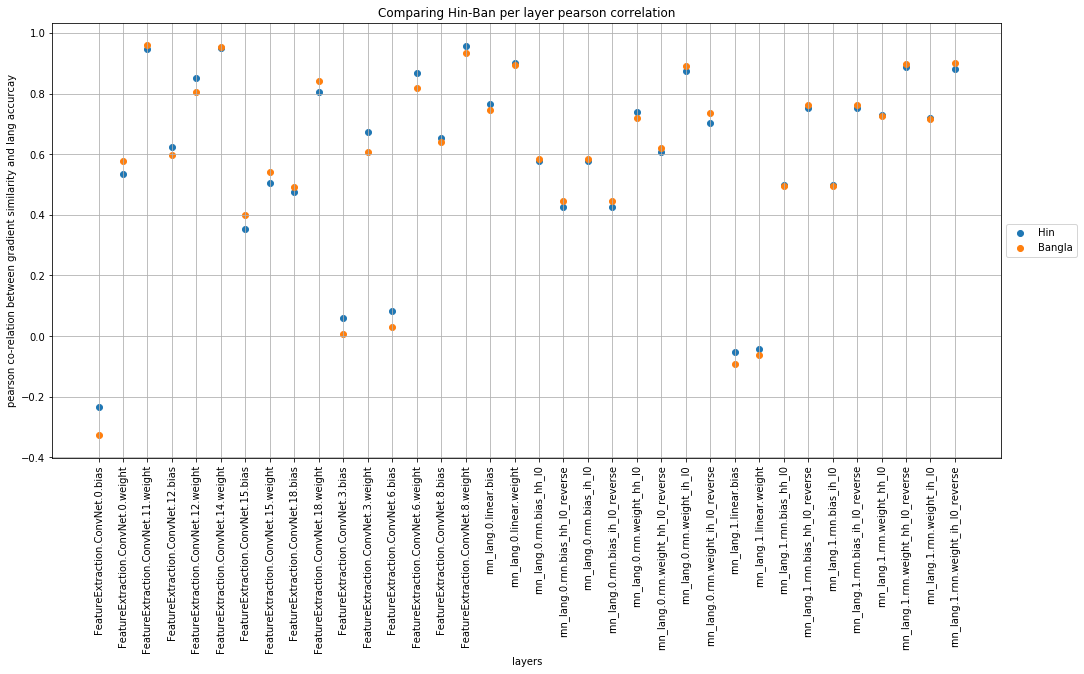

In [80]:
labels = p_hinacc.keys()
values = p_hinacc.values()
fig, axs = plt.subplots(figsize=(20,8))
axs.tick_params(axis='x', rotation=90)
box = axs.get_position()
axs.set_title('Comparing Hin-Ban per layer pearson correlation')
axs.set_position([box.x0, box.y0, box.width * 0.85, box.height])
plt.scatter(list(labels), list(values),label='Hin')
plt.scatter(list(labels),list(p_banacc.values()),label='Bangla')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel('layers')
axs.set_ylabel('pearson co-relation between gradient similarity and lang accurcay')
axs.grid(True)
plt.show()


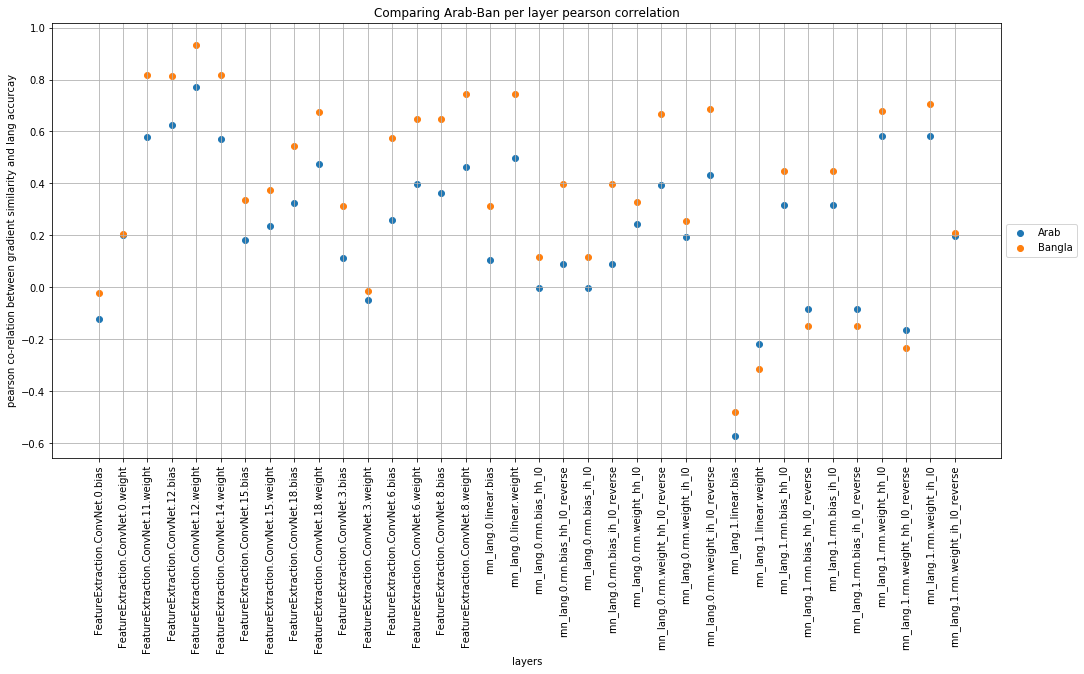

In [79]:
labels = p_hinacc.keys()
values = p_arabacc.values()
fig, axs = plt.subplots(figsize=(20,8))
axs.tick_params(axis='x', rotation=90)
box = axs.get_position()
axs.set_title('Comparing Arab-Ban per layer pearson correlation')
axs.set_position([box.x0, box.y0, box.width * 0.85, box.height])
plt.scatter(list(labels), list(values),label='Arab')
plt.scatter(list(labels),list(p_banacc_AB.values()),label='Bangla')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel('layers')
axs.set_ylabel('pearson co-relation between gradient similarity and lang accurcay')
axs.grid(True)
plt.show()


In [101]:
p_AH_A, p_AH_H = compute_per_layer_pearsonc(grad_sims_AH,acc_AH_A,acc_AH_H)

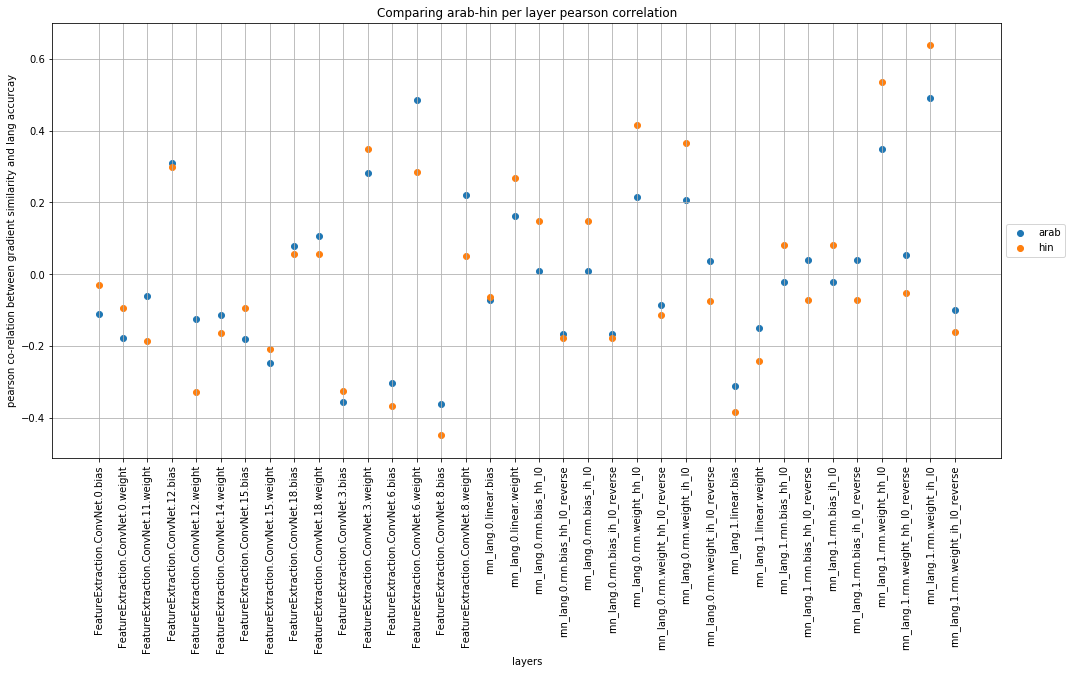

In [104]:
plot_pearsonc(p_AH_A,'arab',p_AH_H,'hin')

In [135]:
pearson_norm_AB = norm1(list(p_arabacc.values()),list(p_banacc_AB.values()))
pearson_norm_BH = norm1(list(p_hinacc.values()),list(p_banacc.values()))
pearson_norm_AH = norm1(list(p_AH_A.values()),list(p_AH_H.values()))
#pearson_norm_BH_trainAB = norm1(p_hinacc,p_arabacc)
print('norm between pearson correlation vectors of arab and bangla [training on Arab-Bangla]:',pearson_norm_AB)
print('norm between pearson correlation vectors of hindi and bangla [training on Hindi-Bangla]:',pearson_norm_BH)
print('norm between pearson correlation vectors of hindi and arab [training on Hindi-Arab]:',pearson_norm_AH)

norm between pearson correlation vectors of arab and bangla [training on Arab-Bangla]: 0.028862099516870687
norm between pearson correlation vectors of hindi and bangla [training on Hindi-Bangla]: 0.0011658233014210095
norm between pearson correlation vectors of hindi and arab [training on Hindi-Arab]: 0.0901937451537761
